# Cassiopeia ecDNA simulations

Here, we simulate a population of cells with extrachromosomal DNA (ecDNA), circular, acentromeric DNA molecules that arise in cancers and segregate randomly at mitosis. The model implemented here is based on that described in [Hung\*, Jones\*, Wong\*, Curtis\*, et al. Coordinated inheritance of extrachromosomal DNA species in human cancer cells. BioRxiv 2023](https://www.biorxiv.org/content/10.1101/2023.07.18.549597v1).

The simulation framework proceeds by simulating successive cell divisions whereby daughter cells recieve some fraction of the parent's ecDNA. It is assumed that ecDNA formation is a rare event and thus not included in this simulation framework (i.e., once a lineage loses ecDNA, it cannot regain it).

In the simplest case, in each cell division an individual ecDNA copy passes to a daughter cell randomly; in other words, we expect the pool of ecDNA to be split up between daughter cells according to a Binomial random process. [Lange et al.](https://www.nature.com/articles/s41588-022-01177-x) previously described that this holds for individual ecDNA species. To model more sophisticated cases of ecDNA co-inheritance (as desribed in [Hung\*, Jones\*, Wong\*, Curtis\*, et al](https://www.biorxiv.org/content/10.1101/2023.07.18.549597v1)), users can make use of the `cosegregation` parameter. 

The simulation frameowrk extends the `BirthDeathFitnessSimlator`.

You can install Cassiopeia by following the guide [here](https://cassiopeia-lineage.readthedocs.io/en/latest/installation.html).

All of our documentation is hosted [here](https://cassiopeia-lineage.readthedocs.io/en/latest/).

In [15]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import cassiopeia as cas

## Simulating independent ecDNA species

The basic unit in this simulation is referred to as an ecDNA "species", each of which can be thought of as a unique oncogene amplification. Here, we show how we can simulate multiple independent ecDNA species with this simulation framework and inspect results.

While an arbitrary number of ecDNA species can be simulated, we simulate 2 independent species.

### Set up parameters & simulate

In addition to the basic parameters fed to `BirthDeathFitnessSimulator`, we specify parameters governing the ecDNA species. At a minimum, the user must provide a array of initial copy-numbers for the parental cell of length $d$ where $d$ is the number of ecDNA species you would like to simulate. In the example below, we simulate two species, both starting from an initial copy-number of 5.

In addition, the user must provide fitness coefficients for each combination of ecDNAs carried in a cell. This is a $2^{d}$ matrix, where the entries denote the relative fitness of a cell carrying a particular combination of ecDNA. For example, in the $d=2$ case:

$$S = \begin{bmatrix} s_{0,0} & s_{0,1} \\ s_{1,0} & s_{1,1} \end{bmatrix}$$

Here $s_{0,0}$ denotes the fitness of cell carrying _neither_ ecDNA, $s_{0,1}$ denotes the fitness of a cell carrying only the second species (but not the first), and $s_{1,1}$ denotes the fitness of a cell carrying both ecDNA. The fitness matrix generalizes to 3 different species where, for example, $s_{0,0,1}$ would denote the fitness of a cell carrying the third species (and neither of the first two), and so forth.

In [25]:
initial_birth_scale = 0.5
death_waiting_distribution = np.random.exponential(3)
num_extant = 200000

# ecDNA parameters
initial_copy_number_array = np.array([5,5])
fitness_array = np.array([[0, 0.1],[0.1,0.1]])

In [26]:
%%time
random_seed = 12345

bd_sim = cas.sim.ecDNABirthDeathSimulator(
    birth_waiting_distribution = lambda scale: np.random.exponential(1/scale),
    initial_birth_scale = initial_birth_scale,
    death_waiting_distribution = lambda: death_waiting_distribution,
    num_extant = num_extant,
    random_seed=random_seed,
    initial_copy_number = initial_copy_number_array,
    splitting_function = lambda c, x: c+np.random.binomial(x, p=0.5), # this means ecDNA is inherited randomly
    fitness_array = fitness_array, 
)
ground_truth_tree = bd_sim.simulate_tree()

# subsample
subsampler = cas.sim.UniformLeafSubsampler(number_of_leaves = 1000)
ground_truth_tree = subsampler.subsample_leaves(ground_truth_tree)

Removing 54285 sublineages.
CPU times: user 28.7 s, sys: 353 ms, total: 29.1 s
Wall time: 29.9 s


### Inspect results

At a most basic level, we can inspect results by plotting the simulated phylogeny and looking at the joint distribution, especially the fraction of cells carrying at least one copy of both ecDNA species and the pearson correlation.

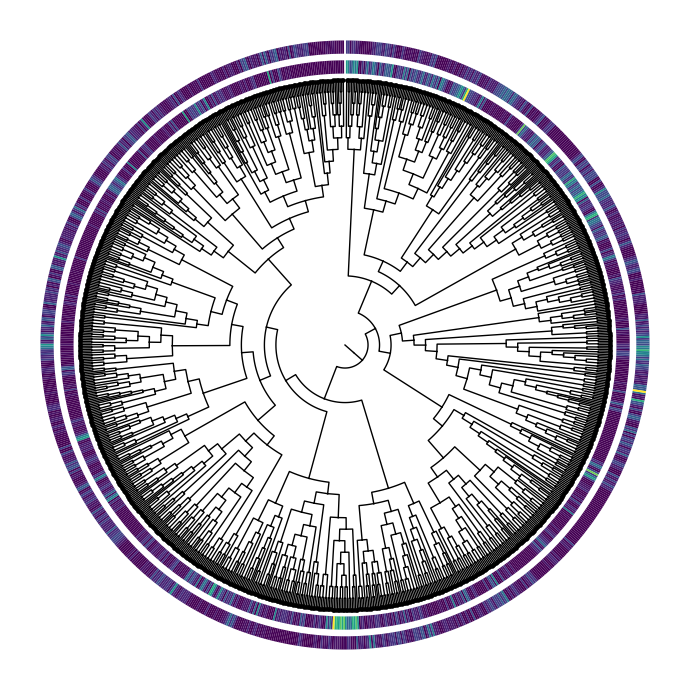

In [27]:
cas.pl.plot_matplotlib(ground_truth_tree, add_root=True, meta_data=['ecDNA_0', 'ecDNA_1'])
plt.show()

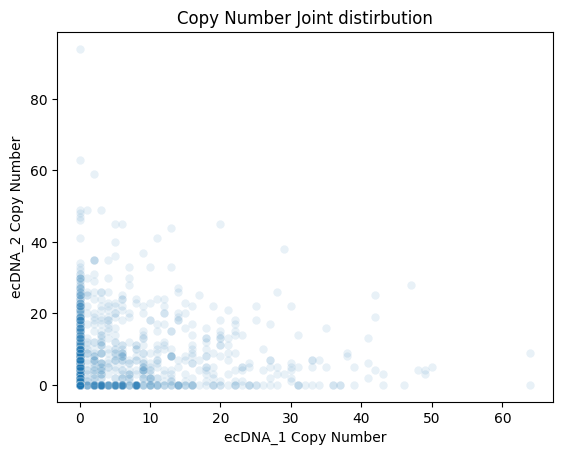

ecDNA copy number correlation: -0.06738845071552513
38.8% of cells carried at least one copy of both ecDNA species
56.5% of cells carried at least one copy of ecDNA species 1.
71.0% of cells carried at least one copy of ecDNA species 2.


In [29]:
sns.scatterplot(x=ground_truth_tree.cell_meta['ecDNA_0'].values, y=ground_truth_tree.cell_meta['ecDNA_1'].values, alpha=0.1)
plt.xlabel("ecDNA_1 Copy Number")
plt.ylabel("ecDNA_2 Copy Number")
plt.title("Copy Number Joint distirbution")
plt.show()

counts = ground_truth_tree.cell_meta
cooccurrence = round(counts[
    (counts["ecDNA_0"] >= 1)
    & (counts["ecDNA_1"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

ecdna_freq_1 = round(counts[
    (counts["ecDNA_0"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

ecdna_freq_2 = round(counts[
    (counts["ecDNA_1"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

correlation = scipy.stats.pearsonr(counts['ecDNA_0'].values, counts['ecDNA_1'].values)[0]

print(f'ecDNA copy number correlation: {correlation}')
print(f'{cooccurrence}% of cells carried at least one copy of both ecDNA species')

print(f'{ecdna_freq_1}% of cells carried at least one copy of ecDNA species 1.')
print(f'{ecdna_freq_2}% of cells carried at least one copy of ecDNA species 2.')


## Simulate co-inheritance

Our recent work has demonstrated that combinations of ecDNA can be co-inherited during mitosis, and our simulation framework can capture this phenomonen with the `cosegregation_coefficient` parameter. This parameter is a float between 0 and 1, where 0 denotes independent inheritance (as above) and 1 denotes perfect co-inheritance where all ecDNA the same fraction of each ecDNA is inherited into a daughter cell. Currently, this cosegregation parameter is only used with respect to the _first_ ecDNA species - in other words, more sophisitcated correlation matrices between multiple ecDNA cannot be modeled at this time.

### Set up simulation and simulate

In [30]:
initial_birth_scale = 0.5
death_waiting_distribution = np.random.exponential(3)
num_extant = 200000

# ecDNA parameters
initial_copy_number_array = np.array([5,5])
fitness_array = np.array([[0, 0.1],[0.1,0.3]])
cosegregation=0.5

In [32]:
%%time
random_seed = 12345

bd_sim = cas.sim.ecDNABirthDeathSimulator(
    birth_waiting_distribution = lambda scale: np.random.exponential(1/scale),
    initial_birth_scale = initial_birth_scale,
    death_waiting_distribution = lambda: death_waiting_distribution,
    num_extant = num_extant,
    random_seed=random_seed,
    initial_copy_number = initial_copy_number_array,
    splitting_function = lambda c, x: c+np.random.binomial(x, p=0.5), # this means ecDNA is inherited randomly
    fitness_array = fitness_array, 
    cosegregation_coefficient=cosegregation
)
ground_truth_tree = bd_sim.simulate_tree()

# subsample
subsampler = cas.sim.UniformLeafSubsampler(number_of_leaves = 2000)
ground_truth_tree = subsampler.subsample_leaves(ground_truth_tree)

Removing 83405 sublineages.
CPU times: user 33.1 s, sys: 294 ms, total: 33.4 s
Wall time: 34.6 s


### Inspect results

Similarly, we can inspect results by viewing the phylogeny and the joint distribution. Notice that with the cosegregation paremeter included we see a marked improvement in the Pearson correlation, which we have described to be a hallmark of ecDNA co-inheritance.

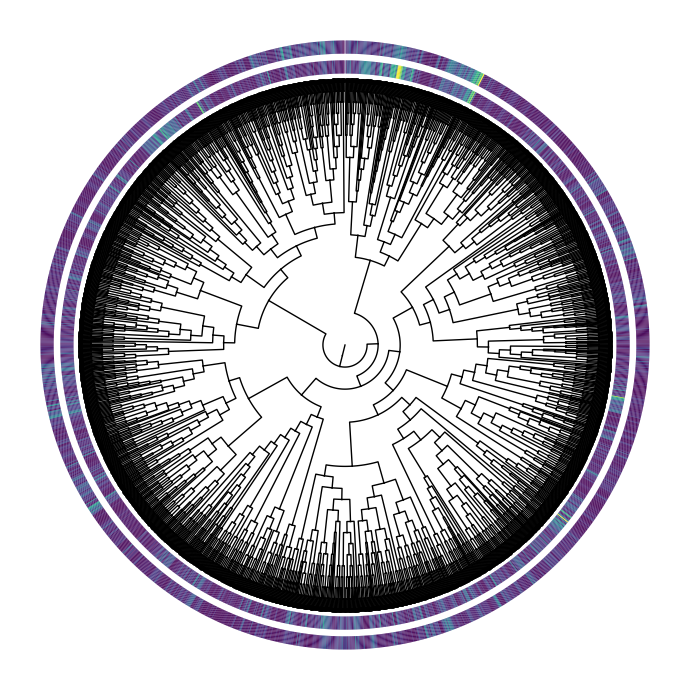

In [33]:
cas.pl.plot_matplotlib(ground_truth_tree, add_root=True, meta_data=['ecDNA_0', 'ecDNA_1'])
plt.show()

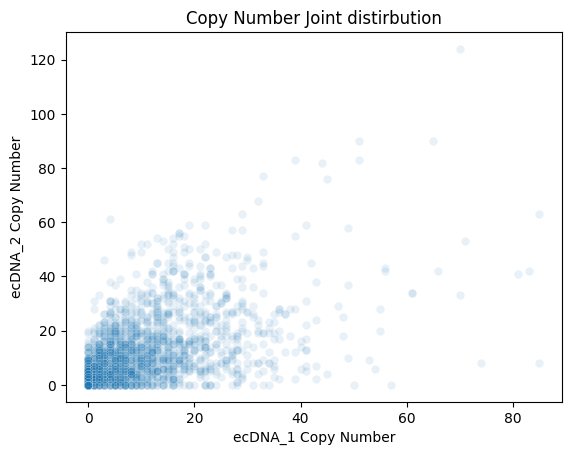

ecDNA copy number correlation: 0.4969485067875421
78.75% of cells carried at least one copy of both ecDNA species
84.7% of cells carried at least one copy of ecDNA species 1.
87.75% of cells carried at least one copy of ecDNA species 2.


In [34]:
sns.scatterplot(x=ground_truth_tree.cell_meta['ecDNA_0'].values, y=ground_truth_tree.cell_meta['ecDNA_1'].values, alpha=0.1)
plt.xlabel("ecDNA_1 Copy Number")
plt.ylabel("ecDNA_2 Copy Number")
plt.title("Copy Number Joint distirbution")
plt.show()

counts = ground_truth_tree.cell_meta
cooccurrence = round(counts[
    (counts["ecDNA_0"] >= 1)
    & (counts["ecDNA_1"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

ecdna_freq_1 = round(counts[
    (counts["ecDNA_0"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

ecdna_freq_2 = round(counts[
    (counts["ecDNA_1"] >= 1)
].shape[0] / counts.shape[0] * 100, 2)

correlation = scipy.stats.pearsonr(counts['ecDNA_0'].values, counts['ecDNA_1'].values)[0]

print(f'ecDNA copy number correlation: {correlation}')
print(f'{cooccurrence}% of cells carried at least one copy of both ecDNA species')

print(f'{ecdna_freq_1}% of cells carried at least one copy of ecDNA species 1.')
print(f'{ecdna_freq_2}% of cells carried at least one copy of ecDNA species 2.')